# ICDEC 2024 Challenge: Vehicle Detection in Various Weather Conditions(VDVWC)

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model

## Checking if gpu is installed

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPUs detected: {physical_devices}")

    for gpu in physical_devices:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU: {gpu}, Name: {gpu_details['device_name']}")
else:
    print("No GPUs detected")


GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), Name: NVIDIA GeForce RTX 2050


I have taken all the image from train and val folder as per class and made it as a single file as per class name
1) rainy_day
2) rainy_night
3) sunny_day
4) sunny_night

and using splitfolders library i have splitted into train,val,test in the ratio of 70,10,20

# Splitting Dataset

In [3]:
import splitfolders
import os
path = "D:\\Scenario\\juvdv2-vdvwc-main"
print(os.listdir(path))

['Rainy_day', 'Rainy_night', 'Sunny_day', 'Suny_night']


In [4]:
output_path = "D:\Scenario\\scenario-split"
splitfolders.ratio(path,seed=1337, output=output_path, ratio=(0.7, 0.1, 0.2))

Copying files: 2800 files [00:05, 484.19 files/s]


## Data processing

In [5]:
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\\Scenario\\scenario-split\\train',
    seed=42,
    image_size= (250, 250),
    batch_size=16,
    color_mode='rgb'
)

Found 2240 files belonging to 4 classes.


In [6]:
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'D:\\Scenario\\scenario-split\\val',
    seed=42,
    image_size= (250, 250),
    batch_size=16,
    color_mode='rgb'
)

Found 284 files belonging to 4 classes.


In [7]:
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'D:\\Scenario\\scenario-split\\test',
    seed=42,
    image_size= (250, 250),
    batch_size=16,
    color_mode='rgb'
)

Found 564 files belonging to 4 classes.


In [8]:
class_names = training_data.class_names
class_names

['Rainy_day', 'Rainy_night', 'Sunny_day', 'Suny_night']

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

## Model Architecture

In [10]:
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), # Conv2D(f_size, filter_size, activation) # relu, sigmoid, softmax
  layers.MaxPooling2D(), # MaxPooling
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 250, 250, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                        

In [12]:
from tensorflow.keras import backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()

In [13]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 10, callbacks=callbacks_list)

Epoch 1/10
140/140 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.8321
Epoch 1: val_accuracy improved from -inf to 0.97183, saving model to model_weights.h5
140/140 [==============================] - 23s 126ms/step - loss: 0.4788 - accuracy: 0.8321 - val_loss: 0.1140 - val_accuracy: 0.9718
Epoch 2/10
140/140 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9772
Epoch 2: val_accuracy did not improve from 0.97183
140/140 [==============================] - 26s 185ms/step - loss: 0.0637 - accuracy: 0.9772 - val_loss: 0.1690 - val_accuracy: 0.9542
Epoch 3/10
140/140 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9888
Epoch 3: val_accuracy improved from 0.97183 to 0.99648, saving model to model_weights.h5
140/140 [==============================] - 16s 117ms/step - loss: 0.0433 - accuracy: 0.9888 - val_loss: 0.0143 - val_accuracy: 0.9965
Epoch 4/10
140/140 [==============================] - ETA: 0s - loss: 0.1279 - accur

In [14]:
model.save('D:\\Scenario\\scenario-split\\vehicle_scenario_detection.h5')

## Evaluation and Results 

In [15]:
accuracy_score = model.evaluate(validation_data)

print(accuracy_score)

print("Accuracy: ", accuracy_score[1])

print("\nTraining Accuracy: {:.2%}".format(accuracy_score[1]))

18/18 [==============================] - 1s 25ms/step - loss: 0.0346 - accuracy: 0.9930
[0.034552425146102905, 0.9929577708244324]
Accuracy:  0.9929577708244324

Training Accuracy: 99.30%


In [14]:
test_loss, test_accuracy = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

36/36 [==============================] - 2s 34ms/step - loss: 0.0127 - accuracy: 0.9929
Test Accuracy: 99.29%


In [32]:
# To clear the cache to use gpu resource efficiently
from tensorflow.keras import backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()


### classification report (with f1 score)

In [16]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []
y_scores = []

for images, labels in testing_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate F1-Score
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

1/1 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

   Rainy_day       0.99      1.00      0.99       141
 Rainy_night       1.00      0.99      1.00       141
   Sunny_day       1.00      0.98      0.99       141
  Suny_night       0.99      1.00      0.99       141

    accuracy                           0.99       564
   macro avg       0.99      0.99      0.99       564
weighted avg       0.99      0.99      0.99       564



In [17]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

### mean average precision

In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

best_model = model

y_true = []
y_pred = []
y_scores = []

for images, labels in testing_data:
    y_true.extend(labels.numpy())
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_scores.extend(predictions)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


# Ensure y_scores is in the shape (num_samples, num_classes)
if y_scores.ndim == 1:
    y_scores = np.expand_dims(y_scores, axis=-1)

# Ensure y_scores has the correct number of samples
num_samples = len(y_true)
if y_scores.shape[0] != num_samples:
    print(f'Error: Number of samples in y_scores ({y_scores.shape[0]}) does not match y_true ({num_samples}).')
else:
    # Calculate mAP
    average_precisions = []
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
        average_precision = average_precision_score(y_true == i, y_scores[:, i])
        average_precisions.append(average_precision)
        print(f'Class {class_names[i]} - AP: {average_precision}')

    mean_ap = np.mean(average_precisions)
    print(f'mAP: {mean_ap}')


1/1 [==============================] - 0s 20ms/step
Class Rainy_day - AP: 1.0
Class Rainy_night - AP: 1.0
Class Sunny_day - AP: 1.0
Class Suny_night - AP: 1.0
mAP: 1.0


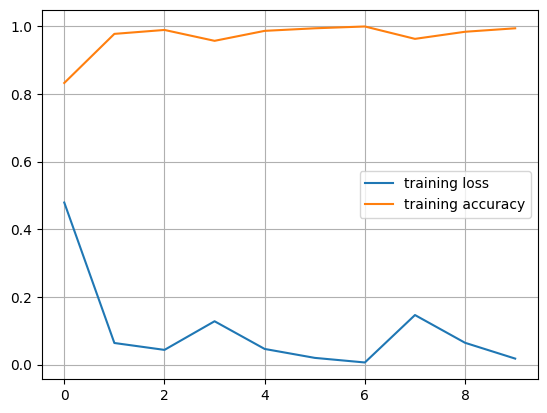

In [20]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

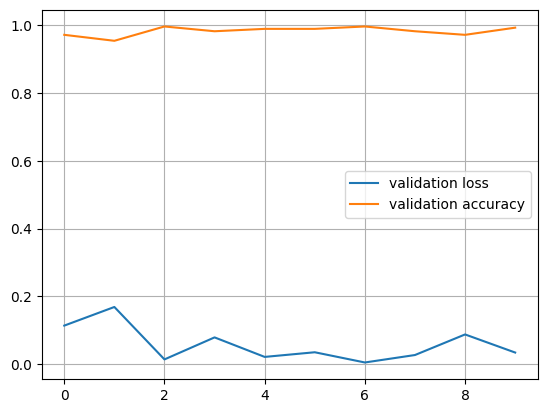

In [21]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

140/140 [==============================] - 3s 22ms/step


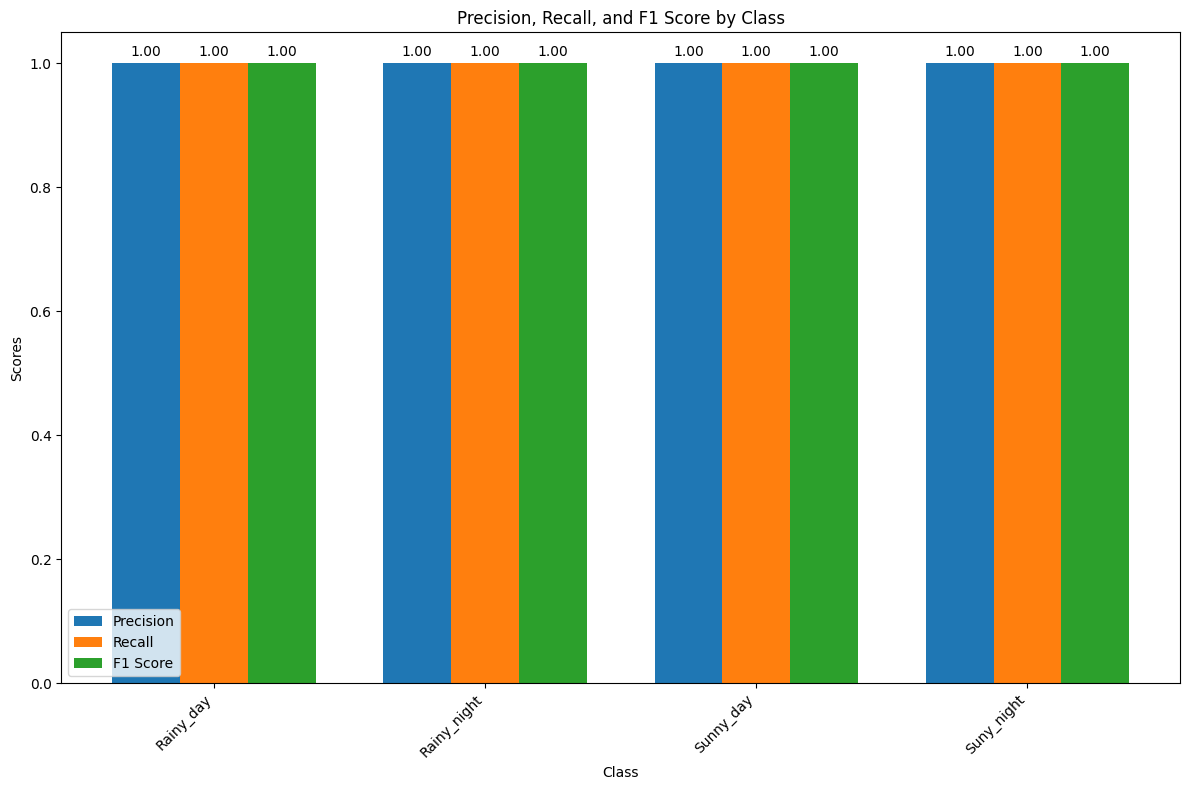

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

true_labels = np.concatenate([y for x, y in training_data], axis=0)
predictions = model.predict(training_data)
predicted_labels = np.argmax(predictions, axis=1)

report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

class_names = list(report.keys())[:-3] 
precision = [report[class_name]['precision'] for class_name in class_names]
recall = [report[class_name]['recall'] for class_name in class_names]
f1_score = [report[class_name]['f1-score'] for class_name in class_names]

x = np.arange(len(class_names)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()
plt.show()

1/1 [==============================] - 0s 22ms/step


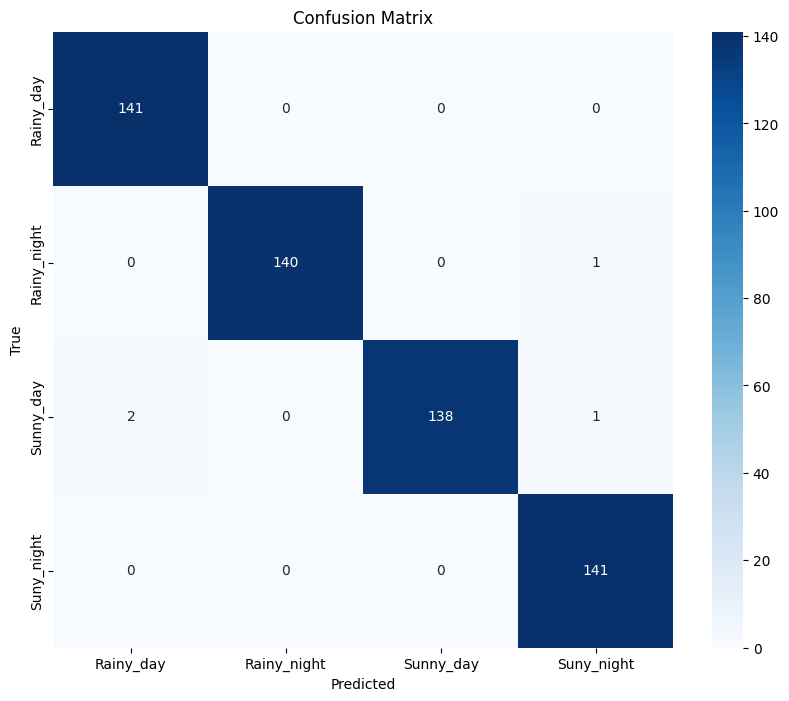

In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the best model

# Get the true labels and predictions for the test set
y_true = []
y_pred = []

for images, labels in testing_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Predictions

1/1 [==============================] - 0s 37ms/step


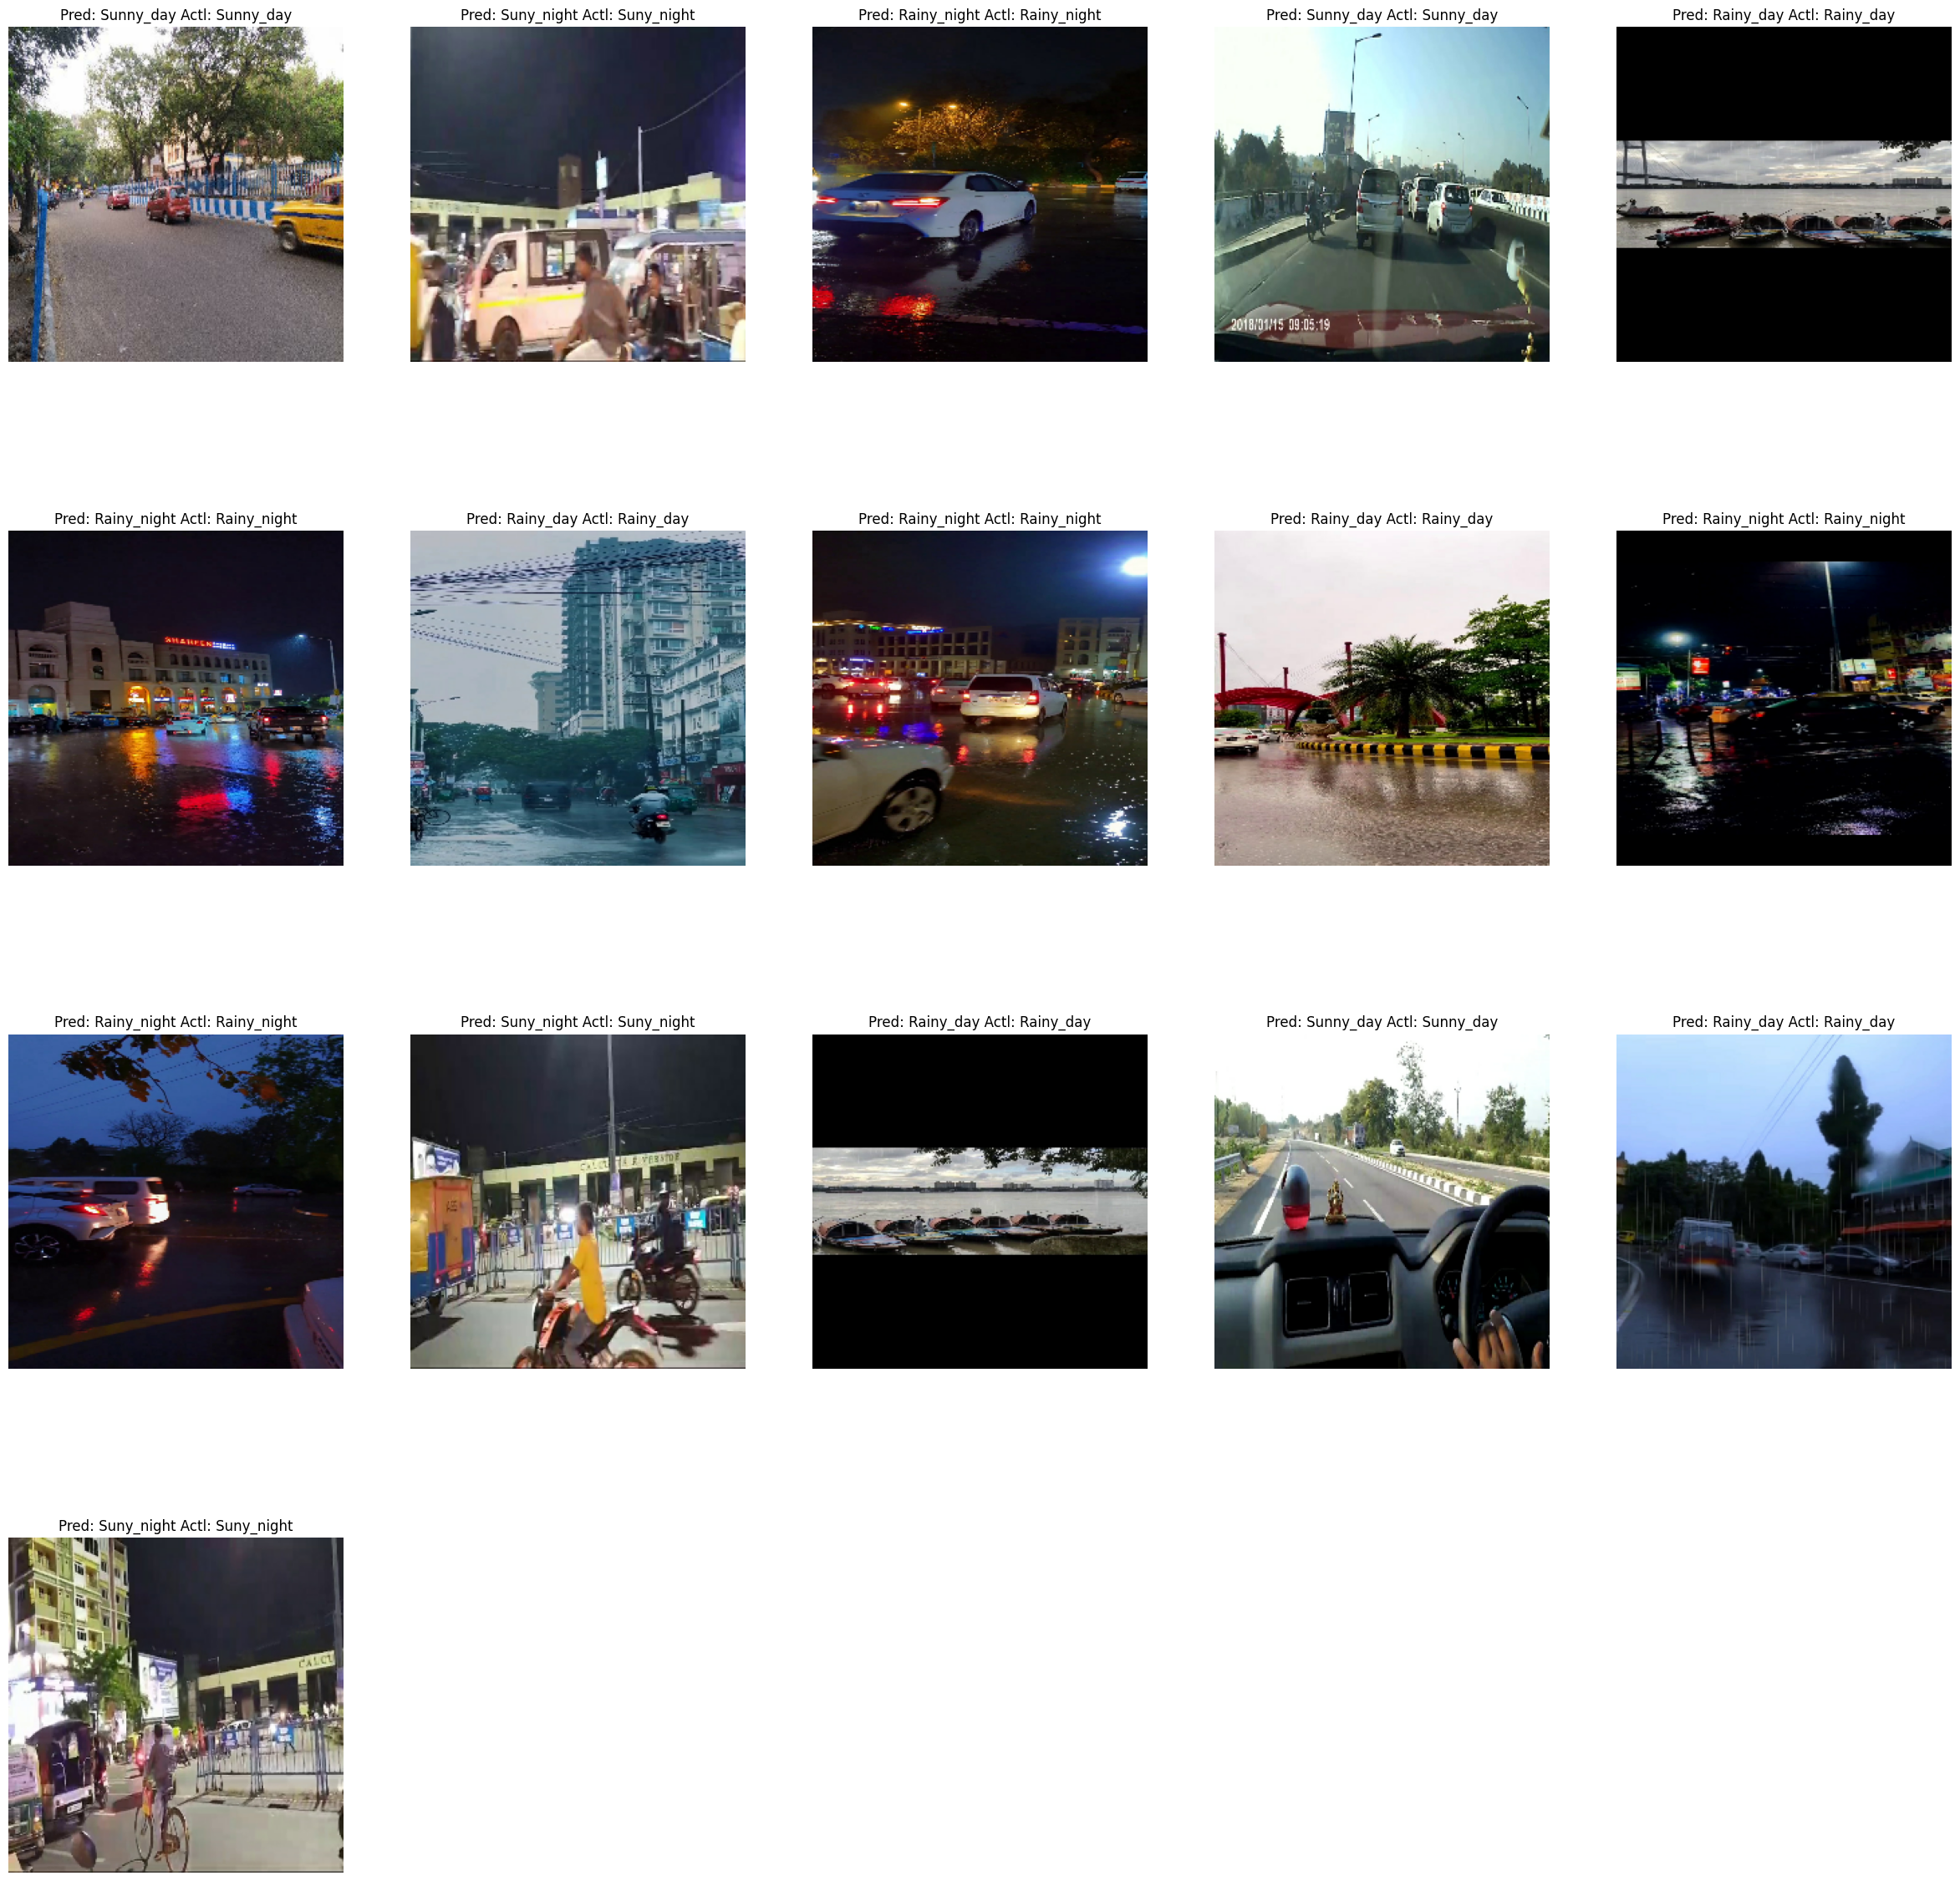

In [24]:
AccuracyVector = []
plt.figure(figsize=(30, 30))

for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels

    num_images = min(16, len(images))

    for i in range(num_images):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: ' + predlabel[i] + ' Actl: ' + class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

plt.show()

1/1 [==============================] - 1s 542ms/step


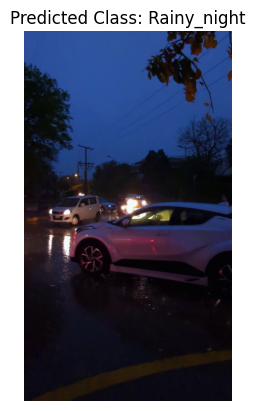

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to read image at {image_path}")

    img = cv2.resize(img, (250, 250)) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_class(image_path, model):
    img = preprocess_image(image_path)

    predictions = model.predict(img)
    
    class_names = ['Rainy_day', 'Rainy_night', 'Sunny_day', 'Sunny_night']
    pred_class = class_names[np.argmax(predictions)]
    
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title('Predicted Class: ' + pred_class)
    plt.axis('off')
    plt.show()

image_path = "D:\\Scenario\\juvdv2-vdvwc-main\\Rainy_night\\rainynight (54).jpg"
predict_class(image_path, model)
